<a href="https://colab.research.google.com/github/tugcegurbuz/MiCM2022_Introduction-to-ML/blob/main/tutorials/Module1B_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 1B - Tutorial 1: Implementing Multi Layer Perceptrons (MLP) with Pytorch

By [Tugce Gurbuz ](https://www.tugcegurbuz.com)as a part of [MiCM-2022](https://www.mcgill.ca/micm/) Introduction to Machine Learning workshop

**Reference:** Adapted from [Neuromatch Academy - Deep Learning Summer School](https://deeplearning.neuromatch.io/tutorials/intro.html) - [W1D3 materials](https://deeplearning.neuromatch.io/tutorials/W1D3_MultiLayerPerceptrons/chapter_title.html)

<p align='center'><img src='https://github.com/tugcegurbuz/MiCM2022_Introduction-to-ML/blob/main/miscellaneous/micm_logo.jpg?raw=True'/></p>

---
# Tutorial objectives

In this tutorial, we will implement the Multi-layer Perceptrons (MLPs). MLPs are arguably one of the most tractable models (due to their flexibility) that we can use to study deep learning fundamentals. 

### Module 1B Slides
If you want to locally download the slides for Module 1B, click [here](https://github.com/tugcegurbuz/MiCM2022_Introduction-to-ML/raw/main/slides/Module1B%20-%20Multi%20Layer%20Perceptrons.pdf).

---
# Setup

This is a GPU free notebook!

In [ ]:
# @title Install dependencies
!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# Generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG','W1D3_T1','https://portal.neuromatchacademy.org/api/redirect/to/9c55f6cb-cdf9-4429-ac1c-ec44fe64c303')

In [ ]:
# Imports
import random

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from IPython.display import display
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# @title Figure settings
import ipywidgets as widgets       # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [ ]:
# @title Plotting functions

def imshow(img):
  """
  Helper function to plot unnormalised image

  Args:
    img: torch.tensor
      Image to be displayed

  Returns:
    Nothing
  """
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def plot_function_approximation(x, relu_acts, y_hat):
  """
  Helper function to plot ReLU activations and
  function approximations

  Args:
    x: torch.tensor
      Incoming Data
    relu_acts: torch.tensor
      Computed ReLU activations for each point along the x axis (x)
    y_hat: torch.tensor
      Estimated labels/class predictions
      Weighted sum of ReLU activations for every point along x axis

  Returns:
    Nothing
  """
  fig, axes = plt.subplots(2, 1)

  # Plot ReLU Activations
  axes[0].plot(x, relu_acts.T);
  axes[0].set(xlabel='x',
              ylabel='Activation',
              title='ReLU Activations - Basis Functions')
  labels = [f"ReLU {i + 1}" for i in range(relu_acts.shape[0])]
  axes[0].legend(labels, ncol = 2)

  # Plot Function Approximation
  axes[1].plot(x, torch.sin(x), label='truth')
  axes[1].plot(x, y_hat, label='estimated')
  axes[1].legend()
  axes[1].set(xlabel='x',
              ylabel='y(x)',
              title='Function Approximation')

  plt.tight_layout()
  plt.show()

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.
# NOTE: This is mostly a GPU free tutorial.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [ ]:
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


---
# Section 1: MLPs in Pytorch

MLPs are fascinating, let's start implementing our first machine learning model right away!

## Coding Exercise 1.1.: Implement a general-purpose MLP architecture in Pytorch
The objective is to design an MLP with these properties:
* Works with any input (1D, 2D, etc.)
* Construct any number of given hidden layers using `nn.Sequential()` and `add_module()` function
* Use the same given activation function (i.e., [Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)) in all hidden layers

**Leaky ReLU** is described by the following mathematical formula:

\begin{align}
\text{LeakyReLU}(x) &= \text{max}(0,x) + \text{negative_slope} \cdot \text{min}(0, x) \\
&=
\left\{
  \begin{array}{ll}
  x & ,\; \text{if} \; x \ge 0 \\
  \text{negative_slope} \cdot x & ,\;  \text{otherwise}
  \end{array}
\right.
\end{align}

In [ ]:
class Net(nn.Module):
  """
  Initialize MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: int
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshaping later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one

      ####################################################################
      # Fill in missing code below (...),
      # Then remove or comment the line below to test your function
      raise NotImplementedError("Create MLP Layer")
      ####################################################################

      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(..., ...) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model with a name

      actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # Forward pass of MLP
    return logits

input = torch.zeros((100, 2))
## Uncomment below to create network and test it on input
# net = Net(actv='LeakyReLU(0.1)', input_feature_num=2, hidden_unit_nums=[100, 10, 5], output_feature_num=1).to(DEVICE)
# y = net(input.to(DEVICE))
# print(f'The output shape is {y.shape} for an input of shape {input.shape}')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D3_MultiLayerPerceptrons/solutions/W1D3_Tutorial1_Solution_4a7c4543.py)



```
The output shape is torch.Size([100, 1]) for an input of shape torch.Size([100, 2])
```

# Section 2: Classification with MLPs

The main loss function we could use for multi-class classification for `N` samples and `C` number of classes is:
* **CrossEntropyLoss**:
This criterion expects a batch of predictions `x` with shape `(N, C)` and class index in the range $[0, C-1]$ as the target (label) for each `N` samples, hence a batch of `labels` with shape `(N, )`. There are other optional parameters like class weights and class ignores. Feel free to check the PyTorch documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) for more detail. Additionally, you can check [here](https://sparrow.dev/cross-entropy-loss-in-pytorch/) to learn appropriate contexts to use the CrossEntropyLoss.

To get CrossEntropyLoss of a sample $i$:

\begin{equation}
\operatorname{loss}(x_i, \text { labels }_i)=-\log \left(\frac{\exp (x[\text { labels }_i])}{\sum_{j} \exp (x[j])}\right)=-x_i[\text { labels }_i]+\log \left(\sum_{j=1}^C \exp (x_i[j])\right)
\end{equation}

### Coding Exercise 2.1: Implement Batch Cross Entropy Loss

To recap, since we will be doing batch learning, we'd like a loss function that given:
* A batch of predictions `x` with shape `(N, C)` 
* A batch of `labels` with shape `(N, )` that ranges from `0` to `C-1`

Returns the average loss $L$ calculated according to:

\begin{align}
loss(x_i, \text { labels }_i) &= -x_i[\text { labels }_i]+\log \left(\sum_{j=1}^C \exp (x_i[j])\right) \\
L &= \frac{1}{N} \sum_{i=1}^{N}{loss(x_i, \text { labels }_i)}
\end{align}

Steps:

1.   Use indexing operation to get predictions of class corresponding to the labels (i.e., $x_i[\text { labels }_i]$)
2.   Compute $loss(x_i, \text { labels }_i)$ vector (`losses`) using `torch.log()` and `torch.exp()` without Loops!
3. Return the average of the loss vector

In [ ]:
def cross_entropy_loss(x, labels):
  """
  Helper function to compute cross entropy loss

  Args:
    x: torch.tensor
      Model predictions we'd like to evaluate using labels
    labels: torch.tensor
      Ground truth

  Returns:
    avg_loss: float
      Average of the loss vector
  """
  x_of_labels = torch.zeros(len(labels))
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  #raise NotImplementedError("Cross Entropy Loss")
  ####################################################################
  # 1. Use indexing operation to get predictions of class corresponding to the labels 
  for i, label in enumerate(labels):
    x_of_labels[i] = x[i, label]
  
  # 2. Loss vector for the batch
  losses = -x_of_labels + ...
  # 3. Return the average of the loss vector
  avg_loss = losses.mean()

  return avg_loss

##Let's test our function for N = 2 samples that has C = 4 classes
labels = torch.tensor([0, 1]) #shape (N,)
x = torch.tensor([[10.0, 1.0, -1.0, -20.0], 
                  [10.0, 10.0, 2.0, -10.0]])
CE = nn.CrossEntropyLoss()
pytorch_loss = CE(x, labels).item()
## Uncomment below to test your function
our_loss = cross_entropy_loss(x, labels).item()
print(f'Our CE loss: {our_loss:0.8f}, Pytorch CE loss: {pytorch_loss:0.8f}')
print(f'Difference between losses: {np.abs(our_loss - pytorch_loss):0.8f}')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D3_MultiLayerPerceptrons/solutions/W1D3_Tutorial1_Solution_0cbf43cb.py)



```
Our CE loss: 0.34672737, Pytorch CE loss: 0.34672749
Difference: 0.00000012
```

## Section 2.2: Spiral Classification Dataset
Before we could start optimizing these loss functions, we need a dataset!

Let's turn this fancy-looking equation into a classification dataset

\begin{equation}
\begin{array}{c}
X_{k}(t)=t\left(\begin{array}{c}
\sin \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma\right) \\
\cos \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma\right) 
\end{array}\right)
\end{array}, \quad 0 \leq t \leq 1, \quad k=1, \ldots, K
\end{equation}

Random seed 42 has been set.


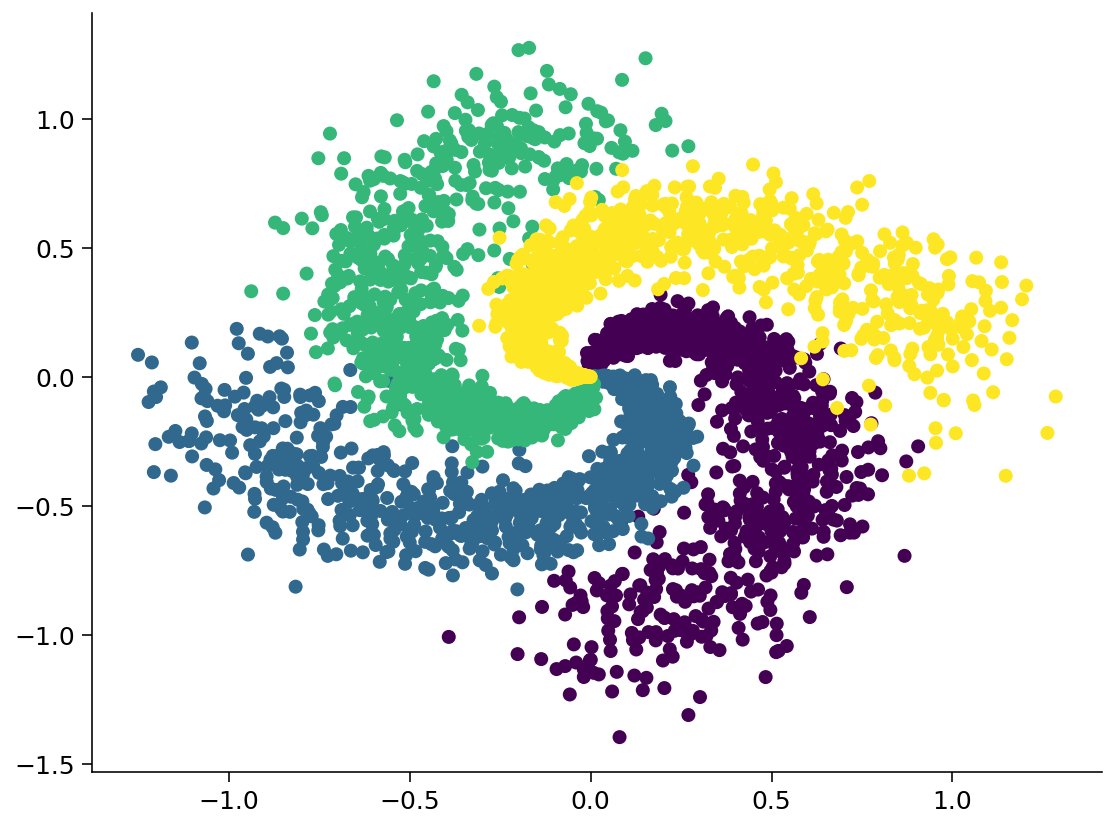

In [ ]:
def create_spiral_dataset(K, sigma, N):
  """
  Function to simulate spiral dataset

  Args:
    K: int
      Number of classes
    sigma: float
      Standard deviation
    N: int
      Number of data points

  Returns:
    X: torch.tensor
      Spiral data
    y: torch.tensor
      Corresponding ground truth
  """

  # Initialize t, X, y
  t = torch.linspace(0, 1, N)
  X = torch.zeros(K*N, 2)
  y = torch.zeros(K*N)

  # Create data
  for k in range(K):
    X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
    X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
    y[k*N:(k+1)*N] = k

  return X, y


# Set parameters
K = 4
sigma = 0.16
N = 1000

set_seed(seed=SEED)
X, y = create_spiral_dataset(K, sigma, N)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.show()

## Section 2.3: Training and Evaluation

### Coding Exercise 2.3: Implement it for a classfication task
Now that we have the spiral dataset and a loss function, it's your turn to implement a simple train/test split for training and validation.

Steps to follow: 
  * Dataset shuffle
  * Train/Test split (20% for test)
  * Dataloader definition
  * Training and Evaluation

In [ ]:
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split incoming data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Shuffle & split data")
  ####################################################################
  # Shuffle data
  shuffled_indices = ...   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(...)    # Assign test dataset size using 20% of samples, use int() to be sure it's not float
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train


## Uncomment below to test your function
# X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=SEED)
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
# plt.title('Test data')
# plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D3_MultiLayerPerceptrons/solutions/W1D3_Tutorial1_Solution_2ea709f4.py)

*Example output:*

<img alt='Solution hint' align='left' width=1120.0 height=832.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D3_MultiLayerPerceptrons/static/W1D3_Tutorial1_Solution_2ea709f4_0.png>



And we need to make a Pytorch data loader out of it. Data loading in PyTorch can be separated in 2 parts:
* Data must be wrapped on a Dataset parent class where the methods __getitem__ and __len__ must be overrided. Note that, at this point, the data is not loaded on memory. PyTorch will only load what is needed to the memory. Here `TensorDataset` does this for us directly.
* Use a Dataloader that will actually read the data in batches and put into memory. Also, the option of `num_workers > 0` allows multithreading, which prepares multiple batches in the queue to speed things up.

In [ ]:
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 128
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=2,
                          worker_init_fn=seed_worker,
                          generator=g_seed)

Let's write a general-purpose training and evaluation code and keep it in our pocket for next tutorials.

In [ ]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.train() #telling our model that we start training
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval() #telling our model that training is finished

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
    print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc

Now let's put everything together and train your first machine learning model!

In [ ]:
set_seed(SEED)
net = Net('ReLU()', X_train.shape[1], [128], K).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 100

_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)

And finally, let's visualize the learned decision-map. We know you're probably running out of time, so we won't make you write code now! But make sure you have reviewed it since we'll start with another visualization technique next time.

In [ ]:
def sample_grid(M=500, x_max=2.0):
  """
  Helper function to simulate sample meshgrid

  Args:
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points

  Returns:
    X_all: torch.tensor
      Concatenated meshgrid tensor
  """
  ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max, M),
                          torch.linspace(-x_max, x_max, M))
  X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)
  return X_all


def plot_decision_map(X_all, y_pred, X_test, y_test,
                      M=500, x_max=2.0, eps=1e-3):
  """
  Helper function to plot decision map

  Args:
    X_all: torch.tensor
      Concatenated meshgrid tensor
    y_pred: torch.tensor
      Labels predicted by the network
    X_test: torch.tensor
      Test data
    y_test: torch.tensor
      Labels of the test data
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points
    eps: float
      Decision threshold

  Returns:
    Nothing
  """
  decision_map = torch.argmax(y_pred, dim=1)

  for i in range(len(X_test)):
    indices = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps
    decision_map[indices] = (K + y_test[i]).long()

  decision_map = decision_map.view(M, M)
  plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
  plt.show()

In [ ]:
X_all = sample_grid()
y_pred = net(X_all)
plot_decision_map(X_all, y_pred, X_test, y_test)

### Think! 2.3.2: Does it generalize well?
Do you think this model is performing well outside its training distribution? Why?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D3_MultiLayerPerceptrons/solutions/W1D3_Tutorial1_Solution_47ad29c3.py)



---
# Summary

In this tutorial, we have explored the Multi-leayer Perceptrons (MLPs). More specifically, we have discussed the similarities between artificial and biological neural networks (for more information see the Bonus section). we have also learned the Universal Approximation Theorem and implemented MLPs in PyTorch.